In [1]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
import pandas as pd
from mesa.time import BaseScheduler

Loading BokehJS ...

### Update from copy_3.py file:
+ Change parameter value
+ change graph
+ change status
+ Warning: Just change self.model.schedule.time => self.schedule.time
+ change contact


<h1 style="color:red">Note: 15th March is the date that the Australian Government enforced the isolation on incoming travellers from the oversee, it means that phase 2 started on this date (in the term of the model, stage 2 - social distancing - starts at step 73)</h1

## Confirmed cases Starting from 25th January

In [29]:
df_confirmed = pd.read_csv(r'D:/notebooks-baseline/datafile/COVID_AU_national_cumulative.csv')

## Bayesian Outputs for False Negative cases starting from 3rd February

## Importation Model Outputs Starting from 1st January

In [68]:
df_importation = pd.read_csv(r'D:/notebooks-baseline/datafile/COVID_importations.csv')
file=df_importation['Estimated COVID importations'][:73]
file=file.astype('int')
file = np.array(file)
file

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         1,   1,   2,   2,   2,   3,   4,   4,   5,   5,   6,   7,   8,
         9,  10,  11,  13,  15,  13,  13,  13,  12,  12,  11,  10,   9,
         8,   7,   6,   5,   5,   5,   5,   6,   6,   8,   8,  10,  12,
        14,  16,  20,  22,  27,  31,  37,  42,  45,  54,  66,  77,  94,
       110, 129, 150, 173, 200, 227, 254, 293])

#### Overide Activation Function to fit with my work

In [69]:
class RandomActivation(BaseScheduler):
    """ A scheduler which activates each agent once per step, in random order,
    with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask agents...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step(model) method.

    """

    def step(self, social = False) -> None:
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        self.social = social 
        for agent in self.agent_buffer(shuffled=True):
            agent.step(social)
 
        self.steps += 1
        self.time += 1

In [133]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    RECOVERED = 3 
    QUARANTINED = 4 
    

class CovidAgent(Agent):
    """This is a class of agents living inside the territory of Australia, each of them have been affected by imported agents"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.state = State.SUSCEPTIBLE 
        self.number_of_contacts = np.random.randint(0,50)
        self.infection_time = 0
        self.incubation_time = 2
        self.recovery_time = 20
        self.rate_infected = 0.52
        self.rate_second_attack = 0.54
        self.quarantine_days = 14 
        self.quarantine_sd = 2 
        self.social = False
    def step(self,social=False):
        """Take a step forwards in time in 2 condition"""
        self.social = social 
        self.status(social)
    
        
                
        self.move() #khong quan trong lam 
        
        self.contact()
        #self.Q_case()
    def move(self):


        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False) if self.model.grid.is_cell_empty(node)]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    
    
    def status(self, social = False):
        """Check infection status 1 if loop for exposed condition and 1 for infected condition"""
        self.social = social #social distancing policy
        if self.state == State.EXPOSED: 
            tmuy = self.schedule.time - self.incubation_time
            self.incubation_period = self.model.get_incubation_time()
            if tmuy >= self.incubation_period: 
                successrate = self.=rate_infected #rate from droplets research (0.543)
                infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                if infect == 1: #if v=0 then the transmission contact becomes ineffective 
                    self.state = State.SUSCEPTIBLE
                else:
                    self.state = State.INFECTED
        
                
        if self.state == State.INFECTED: 
            #self.contact()
            t = self.model.schedule.time -self.infection_time

            if t >= self.model.recovery_days:     
                #successrate = 0.8 
                #infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                if self.random.random()<0.8: 
                    self.state = State.RECOVERED
                


                
        if self.state == State.RECOVERED:
            rate = self.rate_second_attack
            infect = np.random.choice([1,0], p=[rate, 1-rate])
            t = self.model.schedule.time -self.recovery_time
            if t>self.model.get_recovery_time():
                if infect == 1: 
                    self.state = State.SUSCEPTIBLE
                else:
                    self.state = State.RECOVERED
        if self.state == State.QUARANTINED: 
            t = self.model.schedule.time -self.quarantine_days
            if t> 0: #people quarantined either become recovered after 14 days or still be confined at their space 
                success = 0.5 #chua biet 
                infect = np.random.choice([1,0], p=[success, 1-success])
                if infect == 1: 
                    self.state = State.RECOVERED
            
            
        
            
   
    def contact(self):
        """Find close contacts and infect"""
        """
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.EXPOSED
                    
                    other.incubation_time = self.model.get_incubation_time()
        """
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptile_neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        for other in susceptile_neighbors: 
            if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:  
                #if self.random.random() <model.ptrans:
                other.state = State.EXPOSED
                other.infection_time = self.model.schedule.time
                other.incubation_time = self.model.get_incubation_time()
    def isolated(self): 
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptile_neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        for other in susceptile_neighbors:
            if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:  
                self.state = State.QUARANTINED 
                self.quarantine_days = self.model.get_quarantine_time()
                if self.random.random() <model.ptrans:
                    other.state = State.EXPOSED
                    other.infection_time = 6
                    other.incubation_time = self.model.get_incubation_time()
                    
            

        """
    
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        for a in susceptible_neighbors:
            if self.random.random() < model.ptrans:
                a.state = State.EXPOSED
                a.incubation_time = self.model.get_incubation_time()
        """

            

SyntaxError: invalid syntax (<ipython-input-133-291925ac4f2b>, line 51)

In [134]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, num_agents=7,num_infected=1,pcontact=0.4, ptrans=0.54, avg_node_degree=3,
                 progression_period=3, progression_sd=2, recovery_rate=0.05, recovery_days=20,
                 recovery_sd=2, incubation_time = 6 , incubation_time_sd = 2, rate_infected = 0.5, rate_second_attack=0.534,quarantine_days=14,quarantine_sd=2):
        #My shit here:
        self.num_nodes = N  
        self.pcontact=pcontact
        self.num_agents= num_agents
        #self.num_nodes = N  
        #self.pcontact=pcontact
        """All parameters"""
        prob = avg_node_degree / self.num_nodes
        self.rate_second_attack = rate_second_attack
        self.initial_outbreak_size = 1
        self.incubation_time = incubation_time
        self.incubation_time_sd = incubation_time_sd
        self.rate_infected = rate_infected
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.recovery_rate = recovery_rate
        self.recovery_days = recovery_days
        self.quarantine_days = quarantine_days
        self.quarantine_sd = quarantine_sd
        
        
        #create network here: 
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        
        self.grid = NetworkGrid(self.G)

        self.schedule = RandomActivation(self) #activate the step of Agents in random orders
        self.running = True
        #self.dead_agents = []
        """2 types of agents: intra-agent and out-agent"""
        H=np.array(self.grid.G.nodes())
        self.list_of_random_nodes = self.random.sample(self.G.nodes(), self.num_agents)
        self.m=[element for element in H if element not in self.list_of_random_nodes]        
        for i in range(self.num_agents):
            a = CovidAgent(self.list_of_random_nodes[i], self)
            self.schedule.add(a)
            a.state=State.SUSCEPTIBLE
            # Add the agent to a random node
       
            self.grid.place_agent(a,self.list_of_random_nodes[i])
        
        
        
        #add agent
        #self.create_agents()
        """
        infected = np.random.choice([0,1], p=[0.98,0.02])
        if infected == 1:
            a.state = State.INFECTED
            a.recovery_time = self.get_recovery_time()
        """
            
            

        self.datacollector = DataCollector(            
            agent_reporters={"State": 'state'})

        
    def create_agents(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            a = CovidAgent(self.rn, self)
            self.schedule.add(a)
            a.state=State.INFECTED
            self.grid.place_agent(a, self.rn)
            a.status()
            # Create intra-agents
            self.m.remove(self.rn)
    def create_agents_second(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            b = CovidAgent(self.rn, self)
            self.schedule.add(b)
            b.state=State.QUARANTINED
            self.grid.place_agent(b, self.rn)
            b.status()
            # Create intra-agents
            self.m.remove(self.rn)
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    def get_quarantine_time(self):
        return int(self.random.normalvariate(self.quarantine_days,self.quarantine_sd))
    def get_incubation_time(self):
        return int(self.random.normalvariate(self.incubation_time, self.incubation_time_sd))
    def step(self, new =1, second_phase=False, social = False):
        #Câu chuyện ở đây là ông cần phải có grid thì mới có agent để add vô, nếu chỉ có add_nodes thì nó quá đơn thuần và không có agent
        self.new = new
        self.second_phase = second_phase
        self.social = social 
        if new == 0: 
            print(self.schedule.time)
        else:
            if second_phase==False:
                self.create_agents()
            if second_phase==True:
                self.create_agents_second()
                
        self.datacollector.collect(self)
        self.schedule.step(social)
        

        

In [135]:
from mesa.datacollection import DataCollector
N=6000

model = NetworkInfectionModel(N,num_agents=50, ptrans=0.54, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
steps = 10
print(file)
for i in range(len(file)):
    if i<30:
        model.step(new=file[i], second_phase=False)
    else: 
        model.step(new=file[i], second_phase=True)


model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

[  0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   2   2   2
   3   4   4   5   5   6   7   8   9  10  11  13  15  13  13  13  12  12
  11  10   9   8   7   6   5   5   5   5   6   6   8   8  10  12  14  16
  20  22  27  31  37  42  45  54  66  77  94 110 129 150 173 200 227 254
 293]
0
1
2
3
4
5
6
7
8
9
10
11


In [136]:
agent_df

State
Step AgentID       
0    1887         0
     2044         0
     4930         0
     4216         0
     4712         0
...             ...
72   172          3
     3064         3
     4638         3
     5258         3
     3175         4

[27889 rows x 1 columns]

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["blue", "orange", "red",])

def plot_grid(model,fig,layout='spring',title='Covid'):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]

    nx.draw(graph, pos, node_size=100, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax,with_labels=True)
    ax.set_title(title)
    return
steps=10
fig,ax=plt.subplots(1,1,figsize=(16,10))

model = NetworkInfectionModel(100,num_agents=50, ptrans=0.1)

model.step()
f=plot_grid(model,fig,layout='spring',title="Covid Transmission")

In [137]:
import pandas as pd
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Recovered','Quarantined']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f
pop=6000
steps=50
st=time.time()
model = NetworkInfectionModel(pop,num_agents=3000,ptrans=0.54, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
for i in range(len(file)):
    if i<30:
        model.step(new=file[i], second_phase=False)
    else: 
        model.step(new=file[i], second_phase=True)
print("Running time:{}".format(time.time()-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))
print("___________________")
print(file)

0
1
2
3
4
5
6
7
8
9
10
11
Running time:9.297165155410767
      Susceptible  Exposed  Infected  Recovered  Quarantined
Step                                                        
0            3000        0         0          0            0
1            3000        0         0          0            0
2            3000        0         0          0            0
3            3000        0         0          0            0
4            3000        0         0          0            0
...           ...      ...       ...        ...          ...
68            740      489      2527        486          158
69            800      499      2611        512          178
70            776      537      2771        557          186
71            770      572      2958        537          244
72            785      556      3187        578          268

[73 rows x 5 columns]
___________________
[  0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   2   2   2
   3   4   4   5   5   6   7   8  

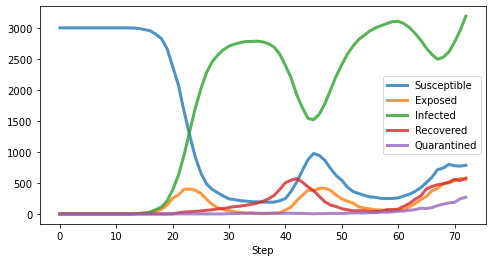

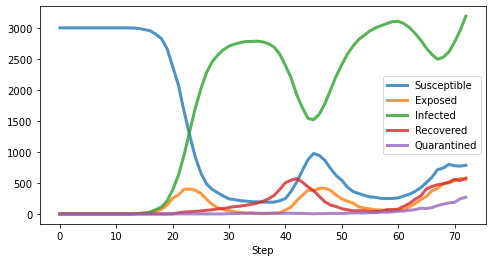

In [138]:
%matplotlib inline

f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)

In [139]:
def run_model(pop, ptrans, degree, steps, delay, layout):

    model = NetworkInfectionModel(pop, ptrans=ptrans, avg_node_degree=degree)

    #fig,ax=plt.subplots(1,1,figsize=(10,8))
    fig1 = plt.Figure(figsize=(8,6))
    #ax1=fig1.add_subplot(1,1,1,label='a')
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    
#run_model(50, 20, 1, 20, 1)
grid_pane = pn.pane.Matplotlib()
states_pane = pn.pane.Matplotlib()
go_btn = pnw.Button(name='run',width=100,button_type='primary')
pop_input = pnw.IntSlider(name='population',value=100,start=10,end=1000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets = pn.WidgetBox(go_btn,pop_input,ptrans_input,degree_input,steps_input,delay_input,layout_input)

def execute(event):
    run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')
    
pn.Row(pn.Column(widgets),grid_pane,states_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='run', width=100)
            [1] IntSlider(end=1000, name='population', start=10, step=10, value=100, value_throttled=100, width=100)
            [2] FloatSlider(name='prob. trans', value=0.1, value_throttled=0.1, width=100)
            [3] IntSlider(end=10, name='node degree', start=1, value=3, value_throttled=3, width=100)
            [4] IntSlider(end=100, name='steps', start=5, value=20, value_throttled=20, width=100)
            [5] FloatSlider(end=3, name='delay', step=0.2, value=0.2, value_throttled=0.2, width=100)
            [6] Select(name='layout', options=['spring', 'circular', ...], value='spring', width=100)
    [1] Matplotlib(None)
    [2] Matplotlib(None)

In [38]:
H = nx.extended_barabasi_albert_graph(n=150,m=2,q=0.007, p=0.0003)
num_agents=10
grid = NetworkGrid(H)
DV=grid.G.degree()
DV[0]

15

In [91]:
84700/get_column_data(model)['Infected'].sum()

0.7200054404189122

In [42]:
grid.G.nodes[120]['agent']

[]

In [ ]:
rnodes = random.sample(G.nodes(), num_agents)

In [ ]:
rnodes
z=[element for element in H if element not in rnodes]
    
    
    

In [ ]:
nx.draw(G,with_labels=True)

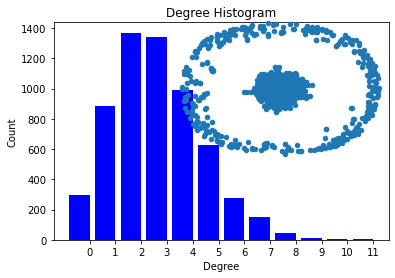

In [108]:
plt.ion()
from itertools import combinations, groupby
import collections
#Degree Distribution
degree_sequence = sorted([d for n, d in model.G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = model.G.subgraph(sorted(nx.connected_components(model.G), key=len, reverse=True)[0])
pos = nx.spring_layout(model.G)
plt.axis("off")
nx.draw_networkx_nodes(model.G, pos, node_size=20)
nx.draw_networkx_edges(model.G, pos, alpha=0.4)
plt.show()

In [126]:
random.normalvariate(5,2)

6.609715089887498